In [4]:
import pandas as pd
from datasets import load_dataset

In [5]:
import zipfile

with zipfile.ZipFile('amazonreviews.zip', 'r') as zip_ref:
    zip_ref.extractall('unzipped')

In [6]:
train_data = pd.read_csv('unzipped/train.ft.txt.bz2', compression='bz2', delimiter='\t', header=None)
test_data = pd.read_csv('unzipped/test.ft.txt.bz2', compression='bz2', delimiter='\t', header=None)

In [7]:
print(train_data.head())
print(test_data.head())

                                                   0
0  __label__2 Stuning even for the non-gamer: Thi...
1  __label__2 The best soundtrack ever to anythin...
2  __label__2 Amazing!: This soundtrack is my fav...
3  __label__2 Excellent Soundtrack: I truly like ...
4  __label__2 Remember, Pull Your Jaw Off The Flo...
                                                   0
0  __label__2 Great CD: My lovely Pat has one of ...
1  __label__2 One of the best game music soundtra...
2  __label__1 Batteries died within a year ...: I...
3  __label__2 works fine, but Maha Energy is bett...
4  __label__2 Great for the non-audiophile: Revie...


In [8]:
def data_view(file):                  
    data = []                                   
    for index, row in file.iterrows():          
        line = row[0]                           
        label, text = line.split(' ', 1)        
        label = label.replace('__label__', '')  
        data.append((label, text.strip()))      
    cols = ['label', 'content']                  
    return pd.DataFrame(data, columns=cols) 

train = data_view(train_data)
train['content'] = train['content'].fillna('')
test = data_view(test_data)

In [9]:
#Checking the label distribution
print(train['label'].value_counts())

label
2    1800000
1    1800000
Name: count, dtype: int64


# Hypothesis 1: positive reviews are longer

In [10]:
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    stop_words='english'  # Use built-in English stop words
)

# Fit and transform the text data
X = vectorizer.fit_transform(train['content'])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

print("Shape of TF-IDF matrix:", X.shape)
print("Number of features:", len(feature_names))
print("First few feature names:", feature_names[:10])

Shape of TF-IDF matrix: (3600000, 5000)
Number of features: 5000
First few feature names: ['00' '000' '10' '100' '1000' '11' '12' '120' '13' '14']


In [12]:
train['review_length'] = train['content'].apply(len)
length_means = train.groupby('label')['review_length'].mean()
print(length_means)

label
1    447.454261
2    415.838369
Name: review_length, dtype: float64


#Write conclucsion on length hypothesis here

# Hypothesis2: Are the reviews with shipping mentioned more positive

In [13]:
shipping_keywords = [
    'shipping', 'delivered', 'delivery', 'amazon logistics', 
    'ship', 'package', 'shipment', 'carrier', 'arrived'
]

def has_shipping_mention(text):
    text_lower = text.lower()
    return any(re.search(r'\b' + keyword + r'\b', text_lower) for keyword in shipping_keywords)

Sentiment Distribution of Reviews:
(Percentage of reviews)
label                         1          2
has_shipping_mention                      
False                 49.785411  50.214589
True                  54.546407  45.453593

Count of Reviews:
has_shipping_mention
False    3437740
True      162260
Name: count, dtype: int64


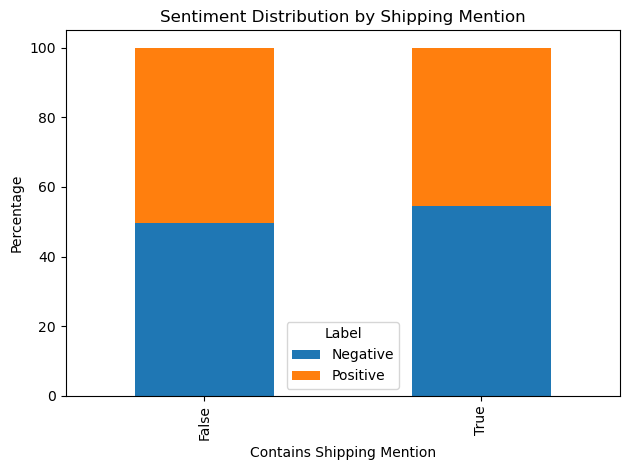

In [14]:
train['has_shipping_mention'] = train['content'].apply(has_shipping_mention)

# Calculate sentiment distribution for reviews with and without shipping mentions
shipping_sentiment_summary = train.groupby('has_shipping_mention')['label'].value_counts(normalize=True).unstack() * 100

print("Sentiment Distribution of Reviews:")
print("(Percentage of reviews)")
print(shipping_sentiment_summary)

# Count of reviews with shipping mentions
shipping_mention_counts = train['has_shipping_mention'].value_counts()
print("\nCount of Reviews:")
print(shipping_mention_counts)


import matplotlib.pyplot as plt

shipping_sentiment_summary.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Shipping Mention')
plt.xlabel('Contains Shipping Mention')
plt.ylabel('Percentage')
plt.legend(title='Label', labels=['Negative', 'Positive'])
plt.tight_layout()
plt.show()

# As per the plot the reviews with shipping mention is actually more negative

# Sentiment Analysis

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [16]:
def extract_top_tfidf_terms(tfidf_matrix, feature_names, label_indices, n_terms=3000):
    """Extract top N terms based on TF-IDF scores for a specific label."""
    avg_tfidf = np.mean(tfidf_matrix[label_indices].toarray(), axis=0)
    top_indices = np.argsort(avg_tfidf)[-n_terms:]
    
    return [feature_names[i] for i in top_indices]

def construct_binary_representation(text, significant_terms):
    """Create binary representation indicating presence/absence of significant terms."""
    tokens = set(word_tokenize(text.lower()))
    return {term: (term in tokens) for term in significant_terms}


In [17]:
# Identify top terms for each label
print("Extracting significant terms per label...")
significant_terms = set()

for label in train['label'].unique():
    label_indices = train['label'] == label
    top_label_terms = extract_top_tfidf_terms(X, feature_names, label_indices)
    significant_terms.update(top_label_terms)

print(f"Total unique significant terms: {len(significant_terms)}")

# Create binary features for training data
print("Generating binary features for training data...")
X_train_binary = []
for text in train['content']:
    features = construct_binary_representation(text, significant_terms)
    X_train_binary.append([int(v) for v in features.values()])
X_train_binary = np.array(X_train_binary)
y_train = train['label']

Extracting significant terms per label...
Total unique significant terms: 3672
Generating binary features for training data...


In [18]:
# Split training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_binary, y_train, test_size=0.2, random_state=42
)

In [19]:
# Train classification model
print("Training classifier...")
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train_split, y_train_split)

# Evaluate on validation set
print("Validation set evaluation:")
y_val_pred = classifier.predict(X_val)
print(classification_report(y_val, y_val_pred))

Training classifier...
Validation set evaluation:
              precision    recall  f1-score   support

           1       0.89      0.87      0.88    359759
           2       0.88      0.89      0.88    360241

    accuracy                           0.88    720000
   macro avg       0.88      0.88      0.88    720000
weighted avg       0.88      0.88      0.88    720000



In [20]:
def predict_text_category(text):
    """Predict category and probabilities for new text."""
    features = construct_binary_representation(text, significant_terms)
    feature_vector = np.array([int(v) for v in features.values()]).reshape(1, -1)
    prediction = classifier.predict(feature_vector)[0]
    probabilities = classifier.predict_proba(feature_vector)[0]
    return prediction, probabilities


In [21]:
# Create binary features for test data
print("Generating binary features for test data...")
X_test_binary = []
for text in test['content']:
    features = construct_binary_representation(text, significant_terms)
    X_test_binary.append([int(v) for v in features.values()])
X_test_binary = np.array(X_test_binary)
y_test = test['label']

# Evaluate on test set
print("Test set evaluation:")
y_test_pred = classifier.predict(X_test_binary)
print(classification_report(y_test, y_test_pred))

# Example prediction
example_text = "If I was a new user, I would be reluctant to buy this product."
predicted_label, confidence_scores = predict_text_category(example_text)
print(f"Predicted Label: {predicted_label}")
print(f"Confidence Scores: {confidence_scores}")

Generating binary features for test data...
Test set evaluation:
              precision    recall  f1-score   support

           1       0.89      0.87      0.88    200000
           2       0.87      0.89      0.88    200000

    accuracy                           0.88    400000
   macro avg       0.88      0.88      0.88    400000
weighted avg       0.88      0.88      0.88    400000

Predicted Label: 1
Confidence Scores: [0.6290495 0.3709505]
